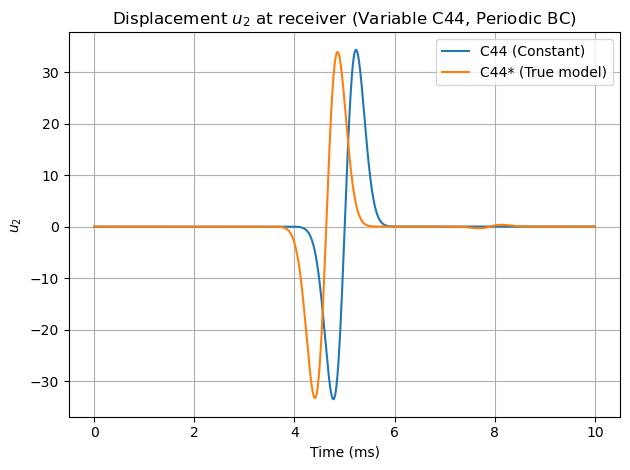

$\chi$=0.7254822034680543


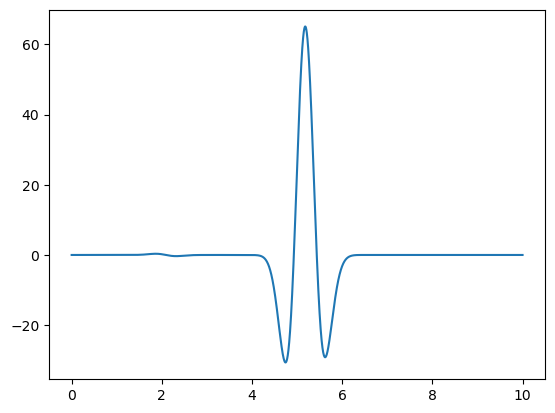

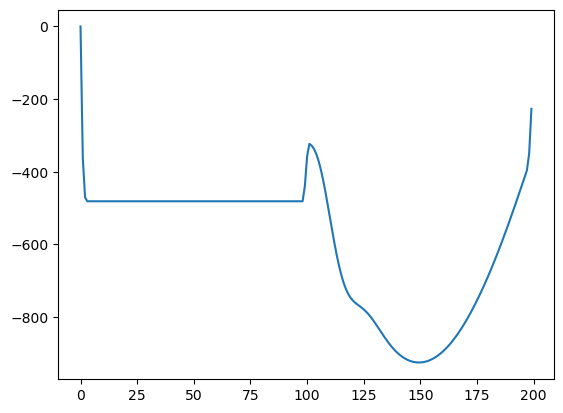

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Grid & time setup ----
nz = 1000
dz = 2e-2
nt = 10000
dt = 1e-6
f0 = 1e3

z = np.arange(nz) * dz
t = np.arange(nt) * dt

# ---- Medium ----
rho = 2000.0
C44_1 = 2.0e9
C44_2 = 3.0e9
vs_1 = np.sqrt(C44_1/rho)
vs_2 = np.sqrt(C44_2/rho)
rho = np.ones(nz) * rho


# ---- Source ----
def ricker(t, f0): 
    t0 = 1/f0
    return (1 - 2*(np.pi*f0*(t - t0))**2) * np.exp(-(np.pi*f0*(t - t0))**2)
src = ricker(t, f0)



import numpy as np
import numpy as np
import numpy as np

def simulate_sh_wave(C44, m, m_lim, src, src_idx, rec_indices, rho, dz, dt, field='u'):
    """
    1D SH wave propagation using flux-form finite differences with variable C44.
    Free-surface (stress-free) boundaries at z=0 and z=L.

    Parameters
    ----------
    C44 : ndarray
        Stiffness array of length nz.
    src : ndarray
        Source time function of length nt.
    src_idx : int
        Index of the source location.
    rec_indices : list[int]
        Indices of receiver locations.
    rho : ndarray
        Density array of length nz.
    dz : float
        Spatial step (m)
    dt : float
        Time step (s)
    field : str
        'u' for displacement, 'dudz' for spatial derivative

    Returns
    -------
    records : ndarray
        Receiver time series (len(rec_indices), nt)
    fullfield : ndarray, optional
        Full wavefield (nz, nt) if requested
    """
    nz = len(C44)
    nt = len(src)
    C44[m_lim[0]:m_lim[1]] = m 
    
    # Initialize fields
    u = np.zeros(nz)
    u_old = np.zeros_like(u)
    u_new = np.zeros_like(u)
    
    # Receivers
    records = np.zeros((len(rec_indices), nt))
    
    # Full field storage
    if field in ['u', 'dudz']:
        fullfield = np.zeros((nz, nt))
    
    # Time stepping
    for it in range(nt):
        # Flux form for variable C44
        C_plus  = 0.5 * (C44 + np.roll(C44, -1))
        C_minus = 0.5 * (C44 + np.roll(C44, 1))

        # Central difference for interior points
        dCdu_dx2 = np.zeros(nz)
        # Interior: i = 1 .. nz-2
        dCdu_dx2[1:-1] = (C_plus[1:-1]*(u[2:] - u[1:-1]) - C_minus[1:-1]*(u[1:-1] - u[:-2])) / dz**2
        # Free-surface boundaries: stress = 0 => derivative = 0
        dCdu_dx2[0] = (C_plus[0]*(u[1] - u[0])) / dz**2
        dCdu_dx2[-1] = (-C_minus[-1]*(u[-1] - u[-2])) / dz**2

        # Time update (second-order)
        u_new[:] = 2*u - u_old + dt**2 * (dCdu_dx2 / rho)

        # Apply Ricker source (spread over a few nodes)
        nodes = np.arange(max(0, src_idx-2), min(nz, src_idx+3))
        weights = np.exp(-0.5*((nodes-src_idx)/1.0)**2)
        weights /= np.sum(weights)
        u_new[nodes] += src[it] * weights / (rho[nodes]*dz)

        # Shift time levels
        u_old[:] = u
        u[:] = u_new

        # Record receivers
        for i, idx in enumerate(rec_indices):
            records[i, it] = u[idx]

        # Store full field if requested
        if field == 'u':
            fullfield[:, it] = u
        elif field == 'dudz':
            # Interior: central difference
            fullfield[1:-1, it] = (u[2:] - u[:-2]) / (2*dz)
            # Boundaries: one-sided second-order
            fullfield[0, it] = (-3*u[0] + 4*u[1] - u[2]) / (2*dz)
            fullfield[-1, it] = (3*u[-1] - 4*u[-2] + u[-3]) / (2*dz)

    if field in ['u', 'dudz']:
        return records, fullfield
    else:
        return records

src_id = 400
rec_id = 600

C44 = np.ones(nz) * C44_1

m = [C44_1]* 200
m_lim = (src_id, rec_id)

records_homo, wavefiled_homo  = simulate_sh_wave(C44, m, m_lim,src, src_idx=src_id, rec_indices=[rec_id], dz=dz, dt=dt, rho=rho, field='dudz')
t_first = (50)*dz / vs_1 + (rec_id)*dz / vs_1 
plt.plot(t*1e3, records_homo[0], label=f'C44 (Constant)')
# plt.axvline(x=t_first*1e3, color='red', linestyle=':', linewidth=1)


m = [C44_1]*100 + [C44_2]*100




records_true = simulate_sh_wave(C44, m, m_lim, src, src_idx=src_id, rec_indices=[rec_id], dz=dz, dt=dt, rho=rho, field=False)
t_first = (50)*dz / vs_1 + (50)*dz / vs_1 + (rec_id - 50)*dz / vs_2

plt.plot(t*1e3, records_true[0], label=f'C44* (True model)')
# plt.axvline(x=t_first*1e3, color='red', linestyle=':', linewidth=1)


plt.xlabel("Time (ms)")
plt.ylabel(r"$u_2$")
plt.title(r"Displacement $u_2$ at receiver (Variable C44, Periodic BC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


def cal_mistif_src_adj(u, u_obs):
     
    res = u_obs - u
    misfit = 0.5 * np.sum(res**2) * dt
    src_adj = np.flip(res)
    
    return misfit, src_adj

mistif, src_adj = cal_mistif_src_adj(records_homo[0],records_true[0])

print(fr"$\chi$={mistif}")


_, wavefiled_adjoint = simulate_sh_wave(C44, m, m_lim,src_adj, src_idx=rec_id, rec_indices=[src_id], dz=dz, dt=dt, rho=rho, field='dudz')

plt.plot(t*1e3, src_adj, label=f'residuals')
plt.show()




def compute_grad(filed_forward, field_adj, m_lim):
    K_c44 = np.sum(np.flip(field_adj[m_lim[0]:m_lim[1],:], axis=1) * filed_forward[m_lim[0]:m_lim[1],:], axis=1) * dt

    return K_c44

K_c44 = compute_grad(wavefiled_homo, wavefiled_adjoint, m_lim)

plt.plot(range(m_lim[1] - m_lim[0]), K_c44)





In [ ]:
import numpy as np

def l_bfgs_inversion_linesearch(m0, C44_full, m_lim, src, src_idx, rec_idx, rho, dz, dt,
                                records_true, max_iter=20, tol=1e-6, m_hist_len=5,
                                alpha_init=0.1, c1=1e-4, max_ls=10):
    """
    L-BFGS inversion for 1D SH wave problem with robust line search.
    
    Parameters
    ----------
    m0 : ndarray
        Initial model for C44 in m_lim.
    C44_full : ndarray
        Full C44 array of length nz.
    m_lim : tuple
        (start, end) indices for the model update.
    src : ndarray
        Source time function.
    src_idx : int
        Source index.
    rec_idx : int
        Receiver index.
    rho : ndarray
        Density array.
    dz, dt : float
        Spatial and temporal steps.
    records_true : ndarray
        Observed data at receiver.
    max_iter : int
        Maximum L-BFGS iterations.
    tol : float
        Gradient norm tolerance.
    m_hist_len : int
        Memory length for L-BFGS.
    alpha_init : float
        Initial step size for line search.
    c1 : float
        Armijo condition constant.
    max_ls : int
        Maximum line search reductions.
    
    Returns
    -------
    m : ndarray
        Inverted model in m_lim.
    misfit_history : list
        Misfit history.
    m_history : list
        Model history at each iteration.
    """
    m = m0.copy()
    misfit_history = []
    m_history = []

    s_list, y_list, rho_list = [], [], []

    for it in range(max_iter):
        # --- Forward simulation ---
        records_homo, wave_forward = simulate_sh_wave(C44_full.copy(), m, m_lim,
                                                       src, src_idx, [rec_idx],
                                                       rho, dz, dt, field='u')

        # Misfit and adjoint source
        misfit, src_adj = cal_mistif_src_adj(records_homo[0], records_true[0])
        misfit_history.append(misfit)
        m_history.append(m.copy())

        # Adjoint simulation
        _, wave_adj = simulate_sh_wave(C44_full.copy(), m, m_lim,
                                       src_adj, src_idx=rec_idx, rec_indices=[src_idx],
                                       rho=rho, dz=dz, dt=dt, field='u')

        # Gradient
        grad = compute_grad(wave_forward, wave_adj, m_lim)
        grad_norm = np.linalg.norm(grad)
        print(f"Iter {it}: misfit = {misfit:.4e}, ||grad|| = {grad_norm:.4e}")
        if grad_norm < tol:
            break

        # --- L-BFGS two-loop recursion ---
        q = grad.copy()
        alpha_list = []

        for s, y, rho_val in zip(reversed(s_list), reversed(y_list), reversed(rho_list)):
            alpha = rho_val * np.dot(s, q)
            alpha_list.append(alpha)
            q -= alpha * y

        gamma = 1.0
        if len(s_list) > 0:
            gamma = np.dot(s_list[-1], y_list[-1]) / (np.dot(y_list[-1], y_list[-1]) + 1e-12)

        r = gamma * q

        for s, y, rho_val, alpha in zip(s_list, y_list, rho_list, reversed(alpha_list)):
            beta = rho_val * np.dot(y, r)
            r += s * (alpha - beta)

        # --- Line search with Armijo condition ---
        alpha = alpha_init
        for ls_iter in range(max_ls):
            m_trial = np.clip(m - alpha * r, 1e8, 1e10)
            records_trial, _ = simulate_sh_wave(C44_full.copy(), m_trial, m_lim,
                                                src, src_idx, [rec_idx],
                                                rho, dz, dt, field='u')
            misfit_trial, _ = cal_mistif_src_adj(records_trial[0], records_true[0])

            if misfit_trial <= misfit - c1 * alpha * np.dot(grad, r):
                break
            alpha *= 0.5  # reduce step

        # --- Accept update ---
        m_new = np.clip(m - alpha * r, 1e8, 1e10)

        # --- Update L-BFGS memory ---
        records_new, wave_forward_new = simulate_sh_wave(C44_full.copy(), m_new, m_lim,
                                                         src, src_idx, [rec_idx],
                                                         rho, dz, dt, field='u')
        _, wave_adj_new = simulate_sh_wave(C44_full.copy(), m_new, m_lim,
                                           cal_mistif_src_adj(records_new[0], records_true[0])[1],
                                           src_idx=rec_idx, rec_indices=[src_idx],
                                           rho=rho, dz=dz, dt=dt, field='u')
        grad_new = compute_grad(wave_forward_new, wave_adj_new, m_lim)

        s_vec = m_new - m
        y_vec = grad_new - grad
        denom = np.dot(y_vec, s_vec)
        rho_val = 1.0 / (denom + 1e-12)

        if len(s_list) >= m_hist_len:
            s_list.pop(0)
            y_list.pop(0)
            rho_list.pop(0)

        s_list.append(s_vec)
        y_list.append(y_vec)
        rho_list.append(rho_val)

        m = m_new

    return m, misfit_history, m_history


Iter 0: misfit = 7.0631e-01, ||grad|| = 2.8049e+02
Iter 1: misfit = 7.0631e-01, ||grad|| = 2.8049e+02
Iter 2: misfit = 2.8298e-01, ||grad|| = 1.7489e-08


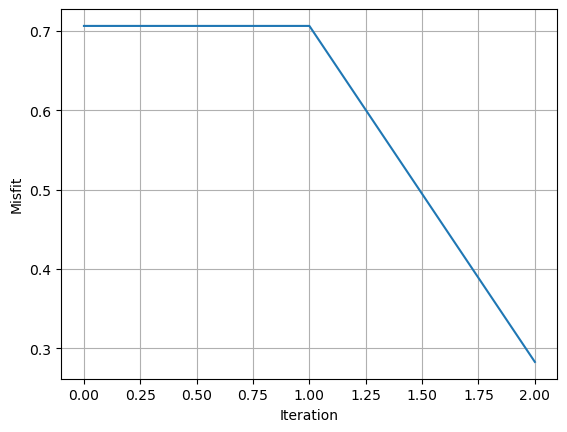

In [37]:
m0 = np.ones(m_lim[1]-m_lim[0]) * C44_1

m_opt, misfit_hist, m_hist = l_bfgs_inversion_linesearch(
    m0, C44, m_lim, src, src_idx=src_id, rec_idx=rec_id,
    rho=rho, dz=dz, dt=dt, records_true=records_true,
    max_iter=10
)

# Plot misfit
plt.plot(misfit_hist)
plt.xlabel("Iteration")
plt.ylabel("Misfit")
plt.grid(True)
plt.show()

# # Plot evolution of first few model parameters
# for i in range(min(5, len(m_hist[0]))):
#     plt.plot([m[i] for m in m_hist], label=f'm[{i}]')
# plt.xlabel("Iteration")
# plt.ylabel("C44 value")
# plt.legend()
# plt.grid(True)
# plt.show()


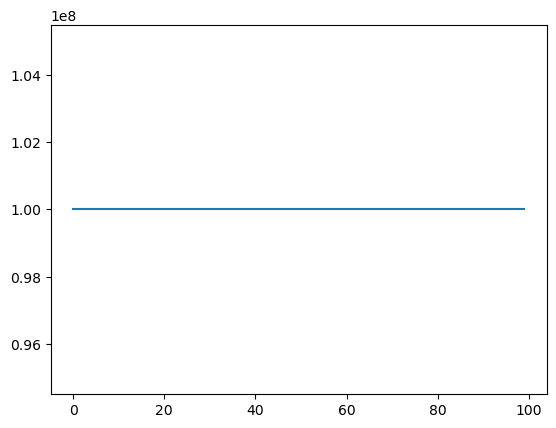

In [41]:
plt.plot(range(m_lim[1]-m_lim[0]), m_hist[2])
